In [2]:
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
from pesummary.io import read
from simple_pe.param_est import SimplePESamples, pe
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS
/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from us

lal.MSUN_SI != Msun


In [29]:
def make_comparison_hists(
    samples_dir, prior_dict=None, outdir=None, bins=20,
    params=['chirp_mass', 'mass_ratio', 'chi_align'],
    truth_dict=None
):

    # Load samples
    m_path = os.path.join(samples_dir, 'metric_samples.dat')
    m_samples = SimplePESamples(read(m_path).samples_dict)
    m_samples.generate_all_posterior_samples()
    m_samples.generate_ecc()
    p_path = os.path.join(samples_dir, 'posterior_samples.dat')
    p_samples = SimplePESamples(read(p_path).samples_dict)
    p_samples.generate_all_posterior_samples()

    # Calculate prior samples if requested
    if prior_dict is not None:
        pr_samples = m_samples
        if prior_dict['iso_spin']:
            pr_samples = pe.isotropic_spin_prior_weight(pr_samples, ['chi_p'])
        if prior_dict['comp_mass']:
            pr_samples = pe.component_mass_prior_weight(pr_samples, ['symmetric_mass_ratio'])
        if prior_dict['ecc'] == 'log-uniform':
            pr_samples = pe.loguniform_e_prior_weight(pr_samples, ['ecc10'])
        elif prior_dict['ecc'] == 'uniform':
            pr_samples = pe.uniform_e_prior_weight(pr_samples, ['ecc10'])           

    # Make plot
    n_cols = (len(params)+1)//2
    plt.figure(figsize=(6.4*n_cols, 4.8*2))
    for i, param in enumerate(params):
        plt.subplot(2, n_cols, i+1)
        try:
            hist_range = (np.min(m_samples[param]), np.max(m_samples[param]))
            plt.hist(m_samples[param], density=True, histtype='step', range=hist_range, bins=bins, color='C0', label='metric_samples')
            if prior_dict is not None:
                plt.hist(pr_samples[param], density=True, histtype='step', range=hist_range, bins=bins, color='C2', label='prior_samples')
        except KeyError:
            hist_range = (np.min(p_samples[param]), np.max(p_samples[param]))
        plt.hist(p_samples[param], density=True, histtype='step', range=hist_range, bins=bins, color='C1', label='posterior_samples')
        if truth_dict is not None:
            try:
                plt.axvline(truth_dict[param], c='k', ls='dashed')
            except KeyError:
                pass
        plt.xlim(hist_range)
        plt.xlabel(param)
        plt.legend()

    # Save plot
    if outdir is not None:
        filename = os.path.join(outdir, 'compare_samples_debug.png')
        plt.savefig(filename)
    plt.show()

2026-02-20  15:17:08 PESummary WARNING : Failed to find 'log_likelihood' in result file. Setting every sample to have log_likelihood 0
2026-02-20  15:17:09 PESummary WARNING : Could not find f_final in input file and one was not passed from the command line. Using 1024.0Hz as default
2026-02-20  15:17:09 PESummary WARNING : Could not find delta_f in input file and one was not passed from the command line. Using 0.00390625Hz as default
2026-02-20  15:17:09 PESummary WARNING : Could not find f_start in input file and one was not passed from the command line. Using 20.0Hz as default
2026-02-20  15:17:09 PESummary WARNING : Could not find f_low in input file and one was not passed from the command line. Using 20.0Hz as default
2026-02-20  15:17:09 PESummary WARNING : Could not find reference_frequency in input file. Using 20Hz as default
2026-02-20  15:17:09 PESummary WARNING : Failed to find 'log_likelihood' in result file. Setting every sample to have log_likelihood 0
2026-02-20  15:17:0

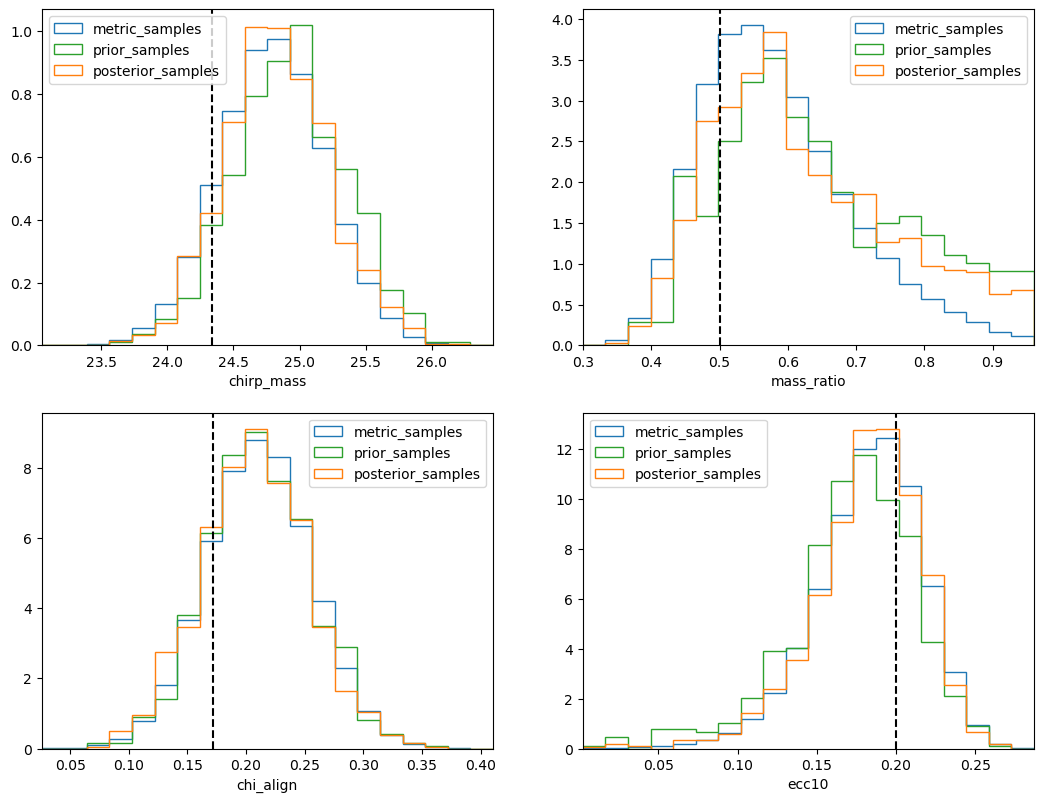

In [36]:
samples_dir = '/home/ben.patterson/projects/EccentricBinaries/notebooks/pipe_ecc_test/ecc_hm_test/outdir/output/'
outdir = samples_dir
prior_dict = {'iso_spin': False, 'comp_mass': True, 'ecc': 'uniform'}
params=['chirp_mass', 'mass_ratio', 'chi_align', 'ecc10']
truth_dict = {'chirp_mass': 24.335, 'mass_ratio': 0.5, 'chi_align': 0.1716, 'ecc10': 0.2}
make_comparison_hists(samples_dir, prior_dict, outdir=outdir, params=params, truth_dict=truth_dict)